# Library Imports

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import networkx as nx
import numpy as np
import os
import csv
import seaborn as sns
from urllib.parse import unquote
from scipy.spatial.distance import cosine
from sentence_transformers import SentenceTransformer
from src.data.paths_loader import load_ai_paths, load_human_paths
from src.utils.evaluation_utils import *


# Content
// TODO: merge

# Data Loading and Preprocessing


In [51]:
paths_df = pd.read_csv("data/wikispeedia_paths-and-graph/paths_finished.tsv", sep="\t", comment='#', header=None,
                       names=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"])

In [52]:
links_df = pd.read_csv('data/wikispeedia_paths-and-graph/links.tsv', sep='\t', comment='#', header=None, names=['origin', 'destination'])
# Create directed graph
G = nx.from_pandas_edgelist(links_df, source='origin', target='destination', create_using=nx.DiGraph())

# load the origin and destination pairs, in the first column
ori_dest = pd.read_csv('ori_dest.csv').iloc[:, 0].tolist()
ori_dest = [eval(pair) for pair in ori_dest]

In [53]:
categories_df = pd.read_csv('data/wikispeedia_paths-and-graph/categories.tsv',
                        sep='\t',
                        comment='#',
                        header=None,
                        names=['article', 'category'])
# unquote
categories_df = categories_df.map(unquote)

# Exploratory Data Analysis

## Path Length Analysis

In [54]:
# Calculate path length
paths_df["path_length"] = paths_df["path"].apply(lambda x: len(x.split(';')))

print("Average corrected path length:", paths_df["path_length"].mean())
print("Corrected path length distribution:\n", paths_df["path_length"].value_counts())

Average corrected path length: 6.757434038738844
Corrected path length distribution:
 path_length
5     10941
4      8558
6      8137
7      5868
8      3954
      ...  
72        1
86        1
71        1
66        1
69        1
Name: count, Length: 79, dtype: int64


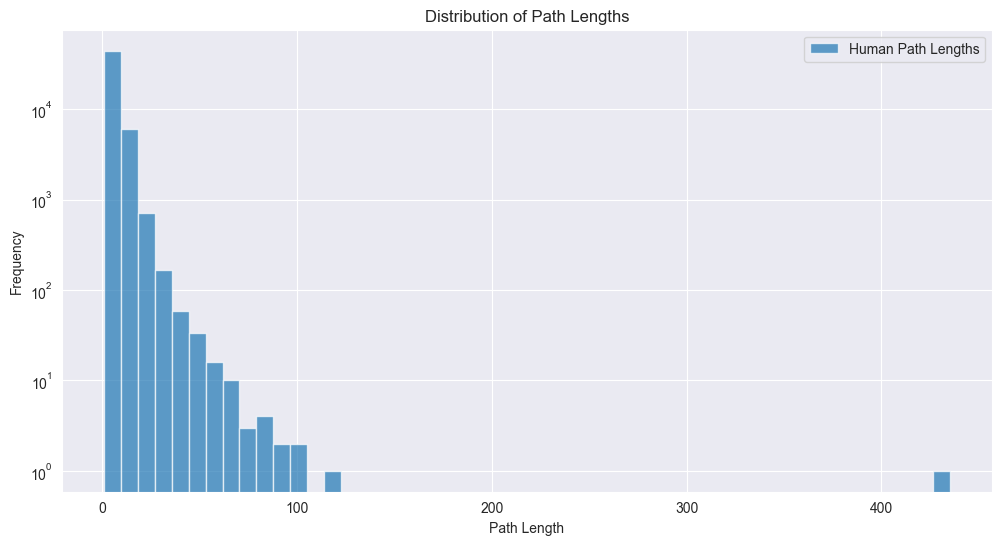

In [55]:
plt.figure(figsize=(12, 6))

# Plot human path lengths
plt.hist(paths_df["path_length"].dropna(), bins=50, alpha=0.7, label='Human Path Lengths')

# Add labels and title
plt.xlabel("Path Length")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Distribution of Path Lengths")
plt.legend(loc='upper right')

# Show the plot
plt.show()

In [56]:
# Get the optimal path length
shortest_path_matrix = dict(nx.all_pairs_shortest_path_length(G))

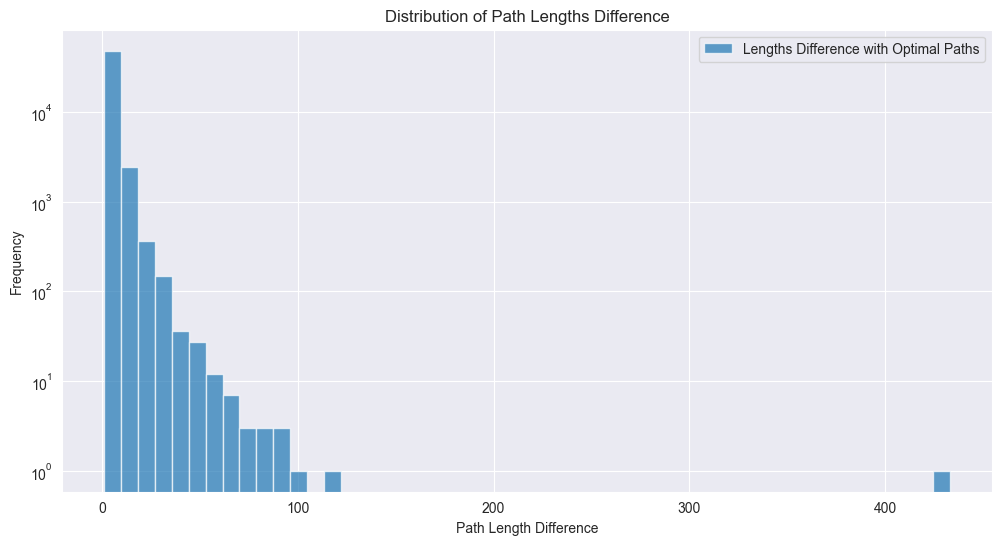

In [57]:
def calculate_shortest_path_length(path):
    articles = path.split(';')
    start_article = articles[0]
    end_article = articles[-1]
    if start_article != end_article:
        try:
            return shortest_path_matrix[start_article][end_article]
        except KeyError:
            return np.nan
    return 0

paths_df["shortest_path_length"] = paths_df["path"].apply(calculate_shortest_path_length)
paths_df["path_length_difference"] = paths_df["path_length"] - paths_df["shortest_path_length"]

plt.figure(figsize=(12, 6))

# Plot human path lengths
plt.hist(paths_df["path_length_difference"].dropna(), bins=50, alpha=0.7, label='Lengths Difference with Optimal Paths')

# Add labels and title
plt.xlabel("Path Length Difference")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Distribution of Path Lengths Difference")
plt.legend(loc='upper right')

# Show the plot
plt.show()

# Comparison with LLM
## Biases in Human and LLM Choices
### Frequency Analysis of Article Categories


In [58]:
# for each pair, load the AI generated path and the human navigated path
AI_paths = load_ai_paths('paths', ori_dest)
human_paths = load_human_paths(ori_dest)
shortest_paths = get_shortest_path(G, ori_dest)

In [73]:
ai_nodes_df = visualize_paths_treemap(AI_paths, categories_df, "AI Paths Category Treemap")

In [74]:
human_nodes_df = visualize_paths_treemap(human_paths, categories_df, "Human Paths Category Treemap")

1. Both "Science" and "Geography" are the most dominant categories in both AI-generated and human-navigated paths, indicating that articles in these fields are either more attractive or more interconnected in the network, regardless of the navigator.

2. The "People" category accounts for a higher percentage in human paths (10.74%) compared to AI paths (6.66%), suggesting that humans tend to navigate towards articles related to daily life or individuals. Similarly, "Everyday_life" has a higher proportion in AI paths (8.87%) than in human paths (7.24%), which may reflect AI's preference for categories with denser interconnections in the network.

### High-Frequency vs Low-Frequency


In [103]:
def calculate_article_frequency(paths):
    article_freq = Counter()
    for path_list in paths.values():
        for path in path_list:
            article_freq.update(path)
    return article_freq

ai_article_freq = calculate_article_frequency(AI_paths)
human_article_freq = calculate_article_frequency(human_paths)

In [118]:
human_article_freq

Counter({'<': 1959,
         'Telephone': 1114,
         'Brain': 1067,
         'Theatre': 908,
         'Zebra': 905,
         'United_States': 781,
         'Mammal': 670,
         'Pyramid': 652,
         'Bean': 643,
         'Africa': 562,
         'Communication': 549,
         'Batman': 534,
         'Computer_science': 522,
         'Lion': 462,
         'Animal': 459,
         'Human': 452,
         'Earth': 407,
         'Agriculture': 403,
         'Computer': 398,
         'Seed': 376,
         'Plant': 372,
         'Bird': 335,
         'Internet': 331,
         'Adolf_Hitler': 324,
         'World_War_II': 308,
         'Information': 289,
         'Europe': 270,
         'Sun': 263,
         'Fruit': 254,
         'Soybean': 252,
         'India': 247,
         'England': 234,
         'Mexico': 228,
         'Technology': 223,
         'Jesus': 222,
         'United_Kingdom': 219,
         'Electronics': 213,
         'Herbivore': 204,
         'Scotland': 194,
      

In [101]:
ai_article_freq

[('Animal', 111),
 ('United_States', 108),
 ('Human', 86),
 ('Christianity', 63),
 ('Batman', 57),
 ('Computer', 57),
 ('Earth', 51),
 ('Adolf_Hitler', 51),
 ('Jesus', 51),
 ('Europe', 48),
 ('Agriculture', 46),
 ('Crime', 45),
 ('Fruit', 39),
 ('Germany', 38),
 ('Culture', 35),
 ('God', 35),
 ('China', 34),
 ('Bird', 31),
 ('Fish', 30),
 ('George_W._Bush', 30),
 ('Mammal', 29),
 ('Plant', 29),
 ('Chordate', 28),
 ('Dog', 28),
 ('Internet', 25),
 ('Microsoft_Windows', 25),
 ('Solar_System', 25),
 ('England', 25),
 ('Electricity', 25),
 ('Evolution', 24),
 ('Biology', 23),
 ('Africa', 22),
 ('Energy', 22),
 ('Citrus', 22),
 ('Egypt', 21),
 ('World_War_II', 21),
 ('Cat', 21),
 ('Chemistry', 21),
 ('Ancient_Egypt', 20),
 ('Film', 19),
 ('Politics', 19),
 ('Insect', 19),
 ('Scientific_classification', 19),
 ('Bible', 18),
 ('Japan', 18),
 ('Vertebrate', 17),
 ('Shark', 17),
 ('Automobile', 17),
 ('Ocean', 17),
 ('British_Empire', 17),
 ('California', 17),
 ('Nintendo', 17),
 ('Beer', 16),


In [104]:
def classify_articles(article_freq, low_percentile=10, high_percentile=90):
    freqs = np.array(list(article_freq.values()))
    low_threshold = np.percentile(freqs, low_percentile)
    high_threshold = np.percentile(freqs, high_percentile)
    common_articles = {article for article, freq in article_freq.items() if freq > high_threshold}
    rare_articles = {article for article, freq in article_freq.items() if freq <= low_threshold}
    return common_articles, rare_articles

ai_common, ai_rare = classify_articles(ai_article_freq)
human_common, human_rare = classify_articles(human_article_freq)

In [115]:
def summarize_categories(article_set, article_freq):
    article_to_category = dict(zip(categories_df['article'], categories_df['category']))
    category_freq = Counter()
    for article in article_set:
        full_category = article_to_category.get(article, "Unknown")
        category_parts = full_category.split('.')
        if len(category_parts) > 1:
            top_category = category_parts[1]  # get the main category
        else:
            top_category = "Unknown"
        category_freq[top_category] += article_freq[article]
    return sorted(category_freq.items(), key=lambda x: x[1], reverse=True)

ai_common_categories = summarize_categories(ai_common, ai_article_freq)
ai_rare_categories = summarize_categories(ai_rare, ai_article_freq)

human_common_categories = summarize_categories(human_common, human_article_freq)
human_rare_categories = summarize_categories(human_rare, human_article_freq)

# print results
print("AI High-Frequency Categories:")
print(pd.DataFrame(ai_common_categories, columns=["Category", "Frequency"]))

print("\nHuman High-Frequency Categories:")
print(pd.DataFrame(human_common_categories, columns=["Category", "Frequency"]))

print("\nAI Low-Frequency Categories:")
print(pd.DataFrame(ai_rare_categories, columns=["Category", "Frequency"]))

print("\nHuman Low-Frequency Categories:")
print(pd.DataFrame(human_rare_categories, columns=["Category", "Frequency"]))

AI High-Frequency Categories:
                 Category  Frequency
0                 Science        694
1               Geography        275
2           Everyday_life        229
3                  People        132
4                Religion        116
5                      IT        107
6                 History         74
7               Countries         73
8             Citizenship         64
9   Design_and_Technology         17
10            Mathematics         16
11                Unknown         16

Human High-Frequency Categories:
                   Category  Frequency
0                   Science      11099
1                 Geography       4109
2             Everyday_life       2622
3     Design_and_Technology       2354
4                   Unknown       2158
5                        IT       1767
6   Language_and_literature       1582
7                   History       1159
8                 Countries        856
9                    People        799
10              Citizenshi

### The position of some high-frequency words

In [116]:
def get_word_positions(paths):
    word_positions = {}
    for path_list in paths.values():
        for path in path_list:
            for i, word in enumerate(path):
                if word not in word_positions:
                    word_positions[word] = []
                word_positions[word].append(i + 1)
    return word_positions

ai_word_positions = get_word_positions(AI_paths)
human_word_positions = get_word_positions(human_paths)


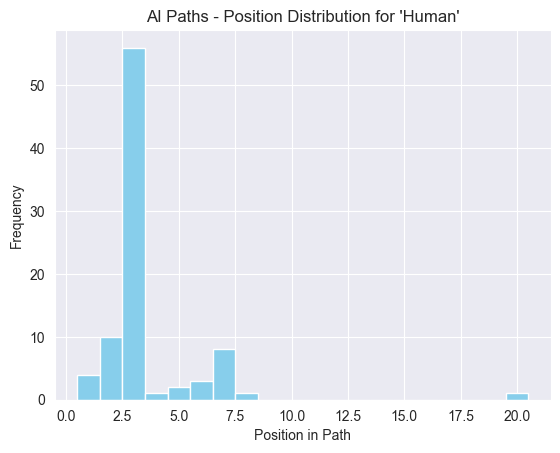

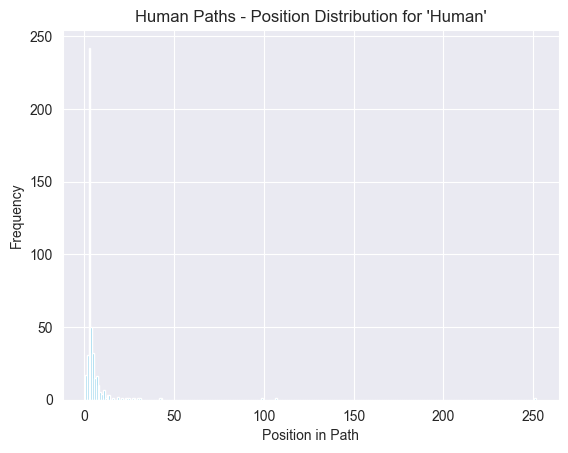

In [119]:
def plot_word_position_distribution(word, word_positions, title):
    positions = word_positions.get(word, [])
    if not positions:
        print(f"{word} not found in paths")
        return

    plt.hist(positions, bins=range(1, max(positions) + 2), align='left', color='skyblue')
    plt.xlabel("Position in Path")
    plt.ylabel("Frequency")
    plt.title(f"{title} - Position Distribution for '{word}'")
    plt.show()

# Human occurs much time in both human-path and ai-path
plot_word_position_distribution("Human", ai_word_positions, "AI Paths")
plot_word_position_distribution("Human", human_word_positions, "Human Paths")
